# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product, islice
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, randint, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

ModuleNotFoundError: No module named 'numpy'

In [182]:
# inicjalizujemy parametry testu

RUNS = 50
EPOCHS = 100
RECOMMENDATION_SIZE = 10

In [183]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [184]:
expected_highest_payout_per_epoch = sum(sorted(
    [arm.activation_probability for arm in arms.values()],
    reverse=True
)[:RECOMMENDATION_SIZE])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.038025239644206


In [185]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)

    def recommend(self, size: int) -> list[str]:
        return sample(self.arm_ids, size)

    def feedback(self, arm_id: str, payout: float) -> None:
        pass

In [186]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] \
                = self.__find_expected_value(arm.payout_function) \
                * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [
            x[0] for x in sorted(
                self.expected_payouts.items(),
                key=lambda x: x[1],
                reverse=True
            )
        ]

    def recommend(self, size: int) -> list[str]:
        return self.arm_ids_sorted_by_expected_payout[:size]

    def feedback(self, arm_id: str, payout: float) -> None:
        pass

    def __find_expected_value(self, payout_function, n=100000) -> float:
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [187]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [188]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(RUNS, EPOCHS, RECOMMENDATION_SIZE)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 602.1400000000001
random: 285.2200000000001


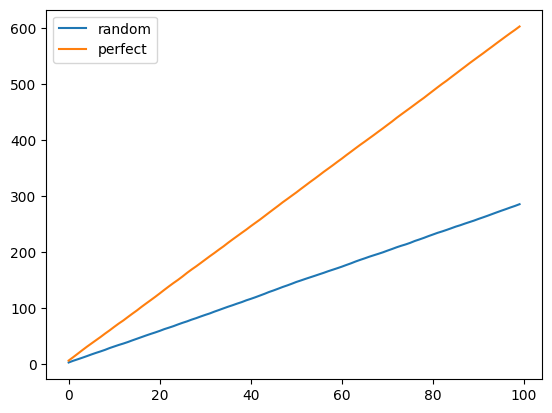

In [189]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, RUNS, EPOCHS, mode='cumulative')


Aggregated results:

perfect: 6.06
random: 3.08


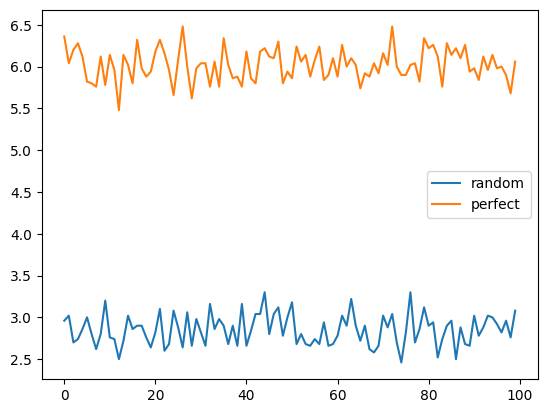

In [190]:
# wyniki per epoka

runner.plot_results(results, RUNS, EPOCHS, mode='average')

## Część 2. - bandyci właściwi

In [191]:
class EGreedy(Bandit):
    def __init__(self, bandit_id: str, arm_ids: list[str], epsilon: float) -> None:
        super().__init__(bandit_id, arm_ids)
        self.arm_ids = arm_ids.copy()
        self.epsilon = epsilon

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size: int) -> list[str]:
        recommendations: list[str] = [None for _ in range(size)]
        sorted_arm_ids = list(map(
            lambda x: x[0],
            sorted(self.ctr.items(), key=lambda x: x[1], reverse=True)
        ))
        random_arm_ids = self.arm_ids.copy()
        shuffle(random_arm_ids)

        for i in range(size):
            x = uniform(0, 1)
            if x > self.epsilon:
                recommendations[i] = sorted_arm_ids[i]
            else:
                recommendations[i] = random_arm_ids[i]

            sorted_arm_ids.remove(recommendations[i])
            random_arm_ids.remove(recommendations[i])

        return recommendations

    def feedback(self, arm_id: str, payout: float) -> None:
        self.impressions[arm_id] += 1
        self.clicks[arm_id] += payout
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

In [192]:
class UCB(Bandit):
    def __init__(self, bandit_id: str, arm_ids: str, optimism_weight: float) -> None:
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.optimistic_ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = 0

    def recommend(self, size: int) -> list[str]:
        return list(map(
            lambda x: x[0],
            islice(sorted(self.optimistic_ctr.items(), key=lambda x: x[1], reverse=True), size)
        ))[:size]

    def feedback(self, arm_id: str, payout: float) -> None:
        self.impressions[arm_id] += 1
        self.total_impressions += 1
        self.clicks[arm_id] += payout
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]
        self.optimistic_ctr[arm_id] \
            = self.ctr[arm_id] + self._optimism(arm_id) * self.optimism_weight

    def _optimism(self, arm: str) -> float:
        return sqrt(2 * log(self.total_impressions) / self.impressions[arm])

In [193]:
class ThompsonSampling(Bandit):
    def __init__(
            self,
            bandit_id: str,
            arm_ids: list[str],
            reward_multiplier: float,
            regret_multiplier: float
            ) -> None:
        super().__init__(bandit_id, arm_ids)
        self.arm_ids = arm_ids.copy()
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1.0 for arm_id in arm_ids}
        self.b = {arm_id: 1.0 for arm_id in arm_ids}
        self.objective_functions = {
            arm_id: betavariate(
                self.a[arm_id], self.b[arm_id]
            ) for arm_id in self.arm_ids
        }

    def recommend(self, size: int) -> list[str]:
        return list(map(
            lambda x: x[0],
            islice(sorted(
                self.objective_functions.items(),
                key=lambda x: x[1],
                reverse=True
            ), size)
        ))

    def feedback(self, arm_id: str, payout: float) -> None:
        if payout > 0.0:
            self.a[arm_id] += self.reward_multiplier * 1
        else:
            self.b[arm_id] += self.regret_multiplier * 1

        a, b = self.a[arm_id], self.b[arm_id]
        self.objective_functions[arm_id] = betavariate(a, b)

## Część 3. - zgrubne porównanie bandytów

In [194]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [195]:
runner = Runner(arms, bandits)
results = runner.simulate(RUNS, EPOCHS, RECOMMENDATION_SIZE)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

perfect: 5.92
ts_1_50: 5.72
ts_5_50: 5.32
ts_10_5: 5.28
ts_20_50: 5.28
ts_1_20: 5.12
ts_20_20: 5.1
ts_5_20: 5.06
ts_10_20: 4.92
egreedy_0.25: 4.86
egreedy_0.1: 4.82
ts_50_10: 4.82
ts_10_10: 4.8
ts_1_10: 4.78
ts_10_50: 4.7
ts_1_1: 4.68
egreedy_0.01: 4.66
ts_5_5: 4.58
ts_5_10: 4.58
ts_10_1: 4.58
egreedy_0.05: 4.56
ts_50_20: 4.56
ts_50_50: 4.48
ts_5_1: 4.4
ts_20_1: 4.36
ts_1_5: 4.26
ts_50_5: 4.22
ts_20_5: 4.14
ucb_10: 4.06
ucb_0.01: 3.94
ucb_0.1: 3.9
ts_20_10: 3.86
ucb_1: 3.66
ts_50_1: 3.32
random: 2.52


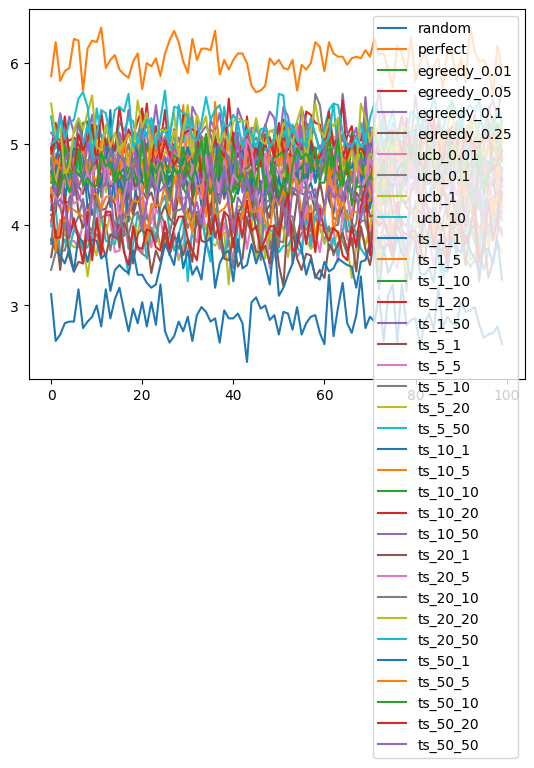

In [196]:
runner.plot_results(results, RUNS, EPOCHS, mode='average')


Aggregated results:

perfect: 602.8599999999999
ts_20_50: 524.6999999999999
ts_1_50: 514.64
ts_20_20: 512.8199999999999
ts_5_50: 510.02000000000004
ts_1_20: 503.4199999999999
ts_5_10: 499.9800000000001
ts_10_20: 499.89999999999975
ts_5_20: 488.9
egreedy_0.05: 481.31999999999994
ts_10_5: 478.85999999999996
egreedy_0.1: 477.28000000000014
ts_1_10: 476.75999999999993
ts_5_5: 476.62
ts_10_50: 476.2
ts_1_5: 472.51999999999987
ts_10_10: 470.93999999999994
ts_10_1: 467.8399999999999
egreedy_0.01: 465.4400000000001
ts_50_10: 462.2800000000001
ts_1_1: 455.6199999999999
egreedy_0.25: 449.82000000000016
ts_20_5: 446.79999999999995
ts_50_50: 429.82
ts_20_1: 424.76000000000005
ts_50_5: 421.8800000000001
ts_20_10: 406.63999999999993
ts_50_20: 393.4800000000001
ucb_10: 389.62
ucb_0.01: 386.43999999999994
ucb_0.1: 386.26000000000005
ucb_1: 385.65999999999997
ts_5_1: 374.06
ts_50_1: 354.71999999999997
random: 284.8000000000001


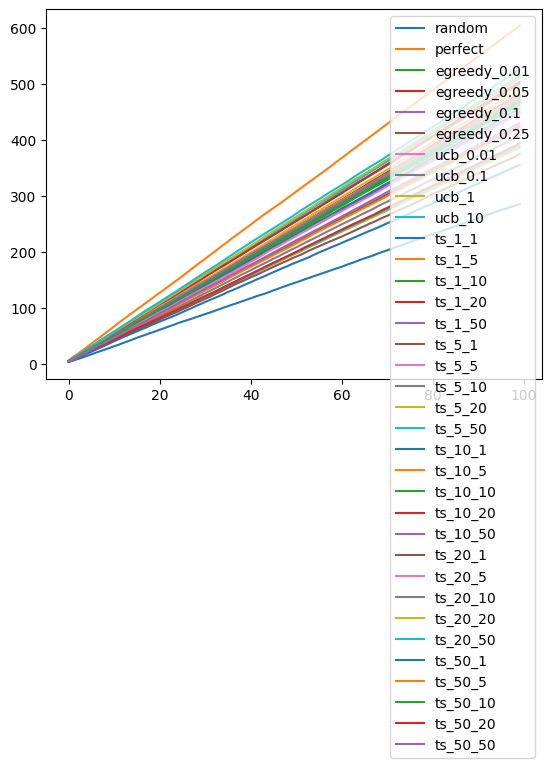

In [197]:
runner.plot_results(results, RUNS, EPOCHS, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [198]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendations: list[Arm]) -> int:
    return len([arm for arm in recommendations if arm.arm_id.startswith('good')])


all_relevant = relevant(arms.values())

In [199]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendations: list[Arm], k: int) -> float:
    k_recommendations = recommendations[:k]
    return relevant(k_recommendations) / len(k_recommendations)


def recall_at_k(recommendations: list[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendations[:k]) / all_relevant

In [200]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(RECOMMENDATION_SIZE)
recommendations = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendations, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendations, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [201]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall

    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: list[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    print(tabulate(data, headers, tablefmt='github'))

In [204]:
def get_bandit_by_id(id: str) -> Bandit:
    return next(filter(lambda bandit: bandit.bandit_id == id, bandits))

# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
    get_bandit_by_id("perfect"),
    get_bandit_by_id("random"),
    get_bandit_by_id("egreedy_0.01"),
    get_bandit_by_id("ucb_0.1"),
    get_bandit_by_id("ts_5_5"),
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results: list[TestEntry] = []

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

for bandit in testing_bandits:
    for k in k_vals:
        print(
            "Evaluating precision@k and recall@k for "
            + f'bandit "{bandit.bandit_id}" and k = {k}'
        )

        precision_sum: float = 0.0
        recall_sum: float = 0.0

        for _ in range(samples):
            recommendation_arm_ids = bandit.recommend(RECOMMENDATION_SIZE)
            recommendation_arms = list(map(
                lambda arm_id: arms[arm_id],
                recommendation_arm_ids
            ))
            precision_sum += precision_at_k(recommendation_arms, k)
            recall_sum += recall_at_k(recommendation_arms, k, all_relevant)

        precision_mean = precision_sum / samples
        recall_mean = recall_sum / samples

        results.append(
            TestEntry(bandit.bandit_id, k, precision_mean, recall_mean)
        )

print()

print_test_results(results)

Evaluating precision@k and recall@k for bandit "perfect" and k = 3
Evaluating precision@k and recall@k for bandit "perfect" and k = 5
Evaluating precision@k and recall@k for bandit "perfect" and k = 10
Evaluating precision@k and recall@k for bandit "random" and k = 3
Evaluating precision@k and recall@k for bandit "random" and k = 5
Evaluating precision@k and recall@k for bandit "random" and k = 10
Evaluating precision@k and recall@k for bandit "egreedy_0.01" and k = 3
Evaluating precision@k and recall@k for bandit "egreedy_0.01" and k = 5
Evaluating precision@k and recall@k for bandit "egreedy_0.01" and k = 10
Evaluating precision@k and recall@k for bandit "ucb_0.1" and k = 3
Evaluating precision@k and recall@k for bandit "ucb_0.1" and k = 5
Evaluating precision@k and recall@k for bandit "ucb_0.1" and k = 10
Evaluating precision@k and recall@k for bandit "ts_5_5" and k = 3
Evaluating precision@k and recall@k for bandit "ts_5_5" and k = 5
Evaluating precision@k and recall@k for bandit "